# CUDA 分块矩阵乘法(Tiled Matrix Multiplication)可视化

这个 notebook 将通过图形化的方式帮助你理解 CUDA 中基于 Tile 的矩阵乘法算法。

## 核心概念
- **Tile（分块）**: 将大矩阵分成小的正方形块
- **Shared Memory**: GPU 中的高速共享内存
- **Thread Block**: CUDA 中的线程块，对应一个 Tile
- **sharedA[TILE_SIZE][TILE_SIZE]**: 二维数组存储矩阵 A 的一个块

让我们通过可视化来深入理解这些概念！

## 1. 导入所需库

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置绘图样式
plt.style.use('default')
fig_size = (12, 8)

## 2. 定义可视化函数

In [2]:
# 定义常量（对应 CUDA 代码中的 TILE_SIZE）
TILE_SIZE = 4  # 为了演示方便，使用较小的 tile size
M, N, K = 8, 8, 8  # 矩阵维度

def draw_matrix(ax, matrix_name, rows, cols, tile_size, highlight_tiles=None, 
                highlight_threads=None, title=""):
    """
    绘制矩阵并高亮显示特定的 tiles 或 threads
    """
    ax.clear()
    
    # 创建网格
    for i in range(rows + 1):
        ax.axhline(y=i, color='black', linewidth=0.5)
    for j in range(cols + 1):
        ax.axvline(x=j, color='black', linewidth=0.5)
    
    # 绘制 tile 边界（粗线）
    for i in range(0, rows + 1, tile_size):
        ax.axhline(y=i, color='red', linewidth=2)
    for j in range(0, cols + 1, tile_size):
        ax.axvline(x=j, color='red', linewidth=2)
    
    # 高亮显示特定的 tiles
    if highlight_tiles:
        for tile_row, tile_col, color in highlight_tiles:
            rect = patches.Rectangle(
                (tile_col * tile_size, tile_row * tile_size), 
                tile_size, tile_size,
                linewidth=3, edgecolor=color, facecolor=color, alpha=0.3
            )
            ax.add_patch(rect)
    
    # 高亮显示特定的线程
    if highlight_threads:
        for thread_row, thread_col, color in highlight_threads:
            rect = patches.Rectangle(
                (thread_col, thread_row), 1, 1,
                linewidth=2, edgecolor=color, facecolor=color, alpha=0.7
            )
            ax.add_patch(rect)
    
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # 让 (0,0) 在左上角
    ax.set_title(f'{matrix_name} {title}', fontsize=14, fontweight='bold')
    
    # 添加坐标标签
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))

def draw_shared_memory(ax, tile_size, data=None, title="Shared Memory"):
    """
    绘制 shared memory 的二维数组结构
    """
    ax.clear()
    
    # 绘制网格
    for i in range(tile_size + 1):
        ax.axhline(y=i, color='black', linewidth=1)
        ax.axvline(x=i, color='black', linewidth=1)
    
    # 如果有数据，显示数据
    if data is not None:
        for i in range(tile_size):
            for j in range(tile_size):
                ax.text(j+0.5, i+0.5, f'{data[i][j]:.1f}', 
                       ha='center', va='center', fontsize=10)
    
    # 添加索引标签
    for i in range(tile_size):
        ax.text(-0.3, i+0.5, f'[{i}]', ha='center', va='center', fontsize=8)
        ax.text(i+0.5, -0.3, f'[{i}]', ha='center', va='center', fontsize=8)
    
    ax.set_xlim(0, tile_size)
    ax.set_ylim(0, tile_size)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

## 3. 原始矩阵的 Tile 划分

让我们看看矩阵是如何被分成小块（Tiles）的：

/tmp/ipykernel_2220079/2638293126.py:17: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2638293126.py:17: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sdp/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sdp/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


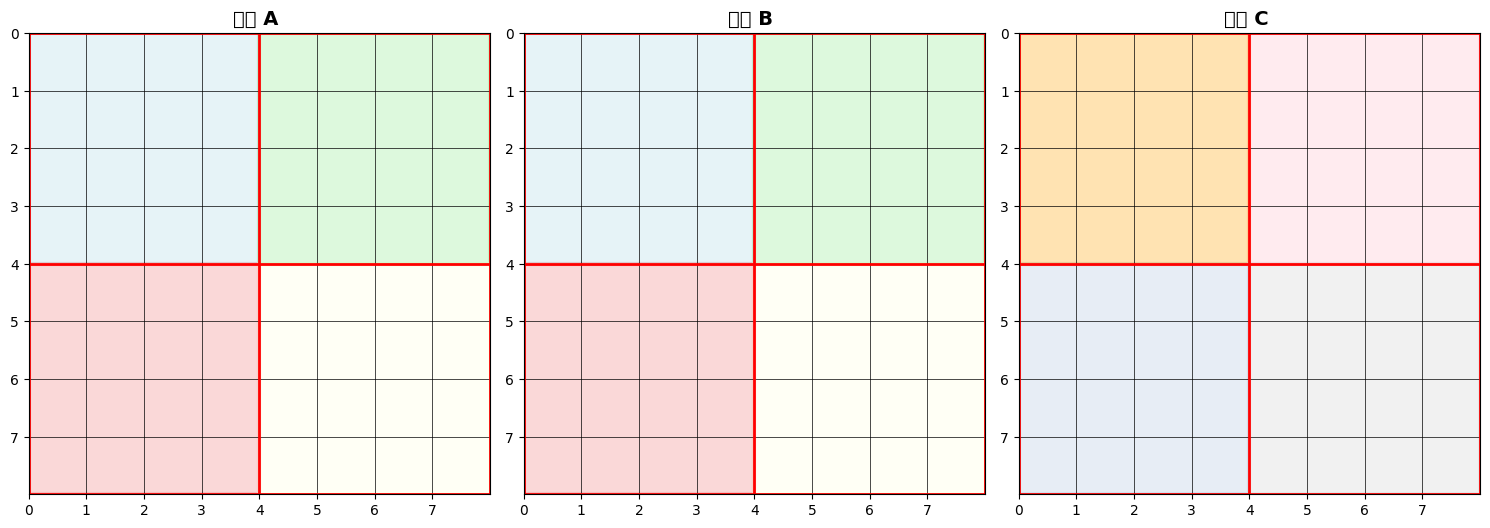

🔍 关键观察：
• 每个彩色方块代表一个 Tile (大小为 4×4)
• 红色粗线是 Tile 的边界
• 每个 CUDA 线程块负责计算矩阵 C 的一个 Tile
• A 矩阵按行分块，B 矩阵按列分块，C 矩阵按行列分块


In [3]:
# 创建图形展示矩阵分块
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制矩阵 A, B, C 的分块
draw_matrix(axes[0], "矩阵 A", M, K, TILE_SIZE, 
           highlight_tiles=[(0, 0, 'lightblue'), (0, 1, 'lightgreen'), 
                           (1, 0, 'lightcoral'), (1, 1, 'lightyellow')])

draw_matrix(axes[1], "矩阵 B", K, N, TILE_SIZE,
           highlight_tiles=[(0, 0, 'lightblue'), (0, 1, 'lightgreen'), 
                           (1, 0, 'lightcoral'), (1, 1, 'lightyellow')])

draw_matrix(axes[2], "矩阵 C", M, N, TILE_SIZE,
           highlight_tiles=[(0, 0, 'orange'), (0, 1, 'pink'), 
                           (1, 0, 'lightsteelblue'), (1, 1, 'lightgray')])

plt.tight_layout()
plt.show()

print("🔍 关键观察：")
print("• 每个彩色方块代表一个 Tile (大小为 4×4)")
print("• 红色粗线是 Tile 的边界")
print("• 每个 CUDA 线程块负责计算矩阵 C 的一个 Tile")
print("• A 矩阵按行分块，B 矩阵按列分块，C 矩阵按行列分块")

## 4. 单个线程块如何加载 Tile 到共享内存

现在让我们深入了解 `sharedA[TILE_SIZE][TILE_SIZE]` 的工作原理：

/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 23616 (\N{CJK UNIFIED IDEOGRAPH-5C40}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2634450865.py:66: UserWarning: Glyph 30697 (\N{CJK UN

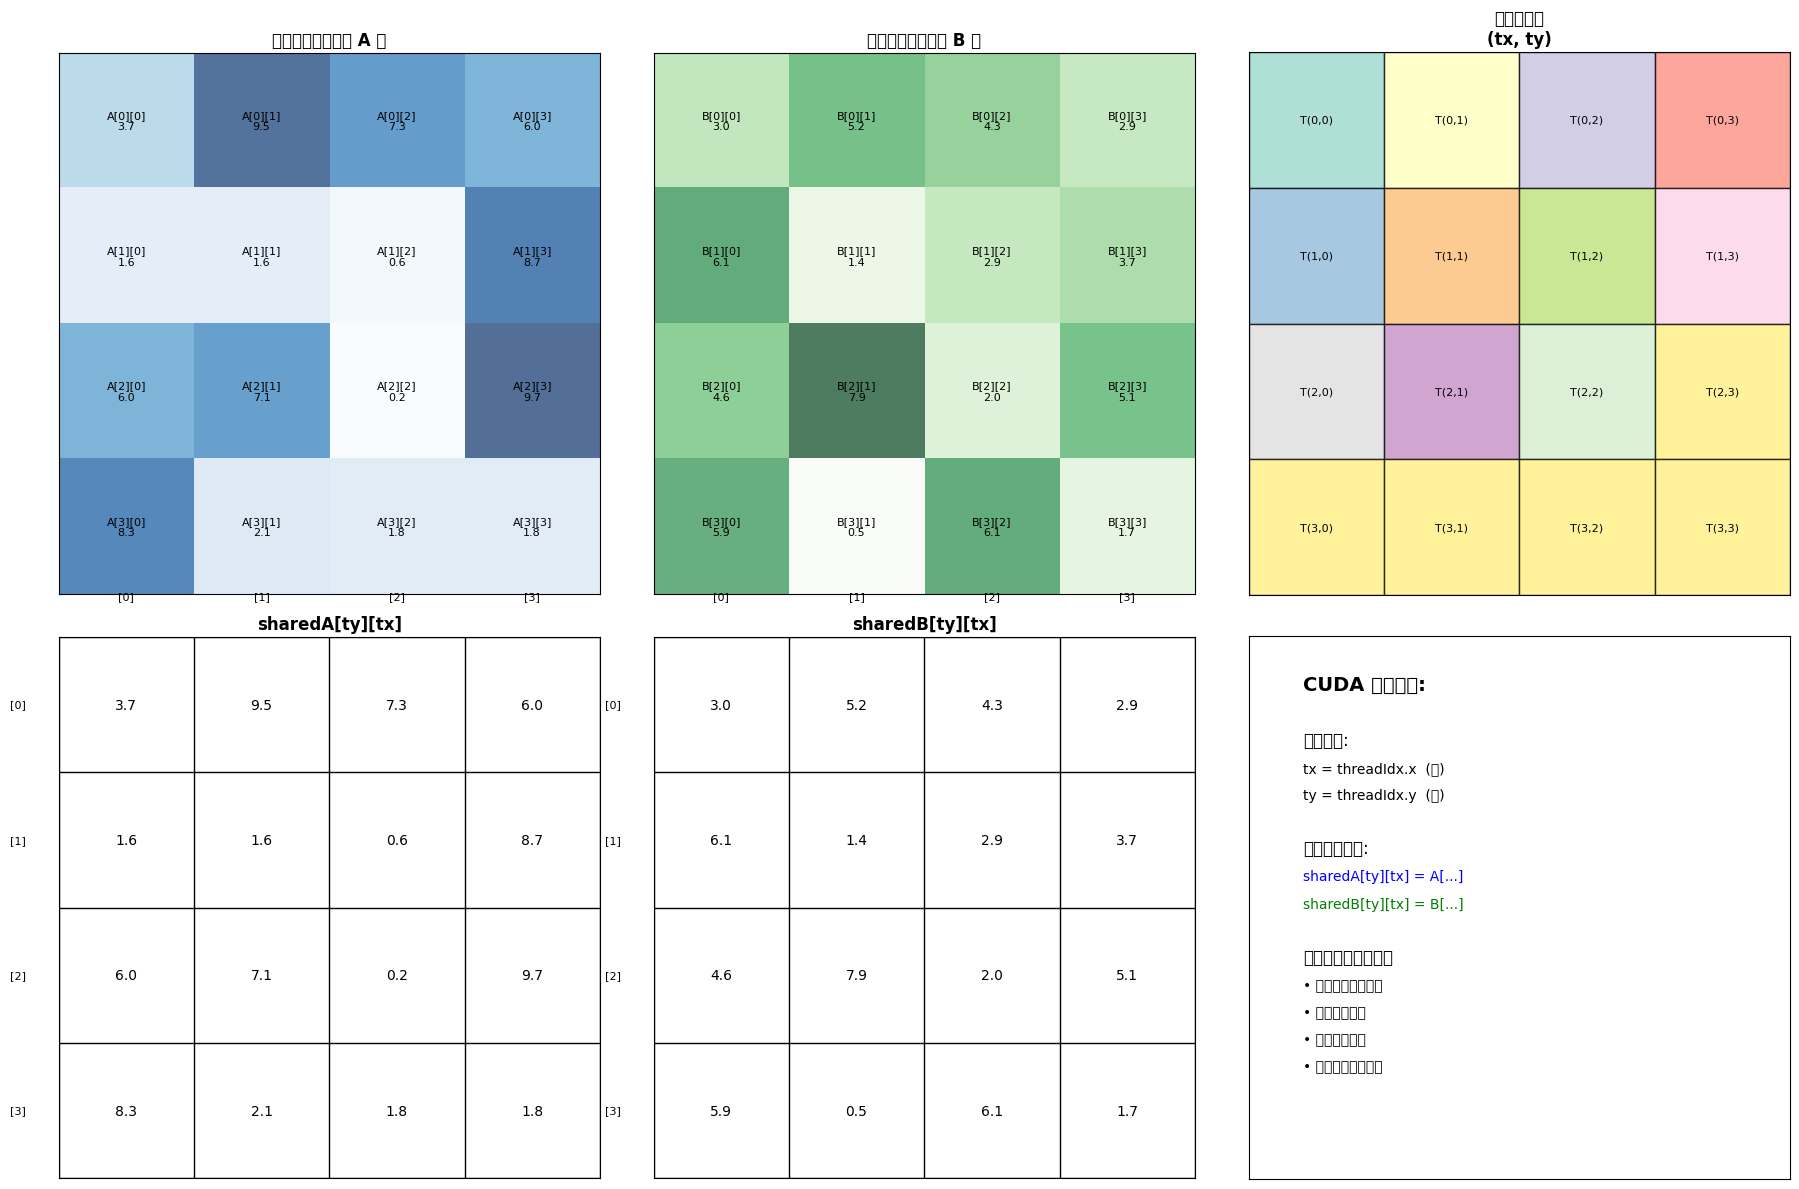

💡 关键理解：
• 每个线程 (tx, ty) 负责加载一个元素到 sharedA[ty][tx]
• 二维数组 sharedA 直接对应矩阵的行列结构
• ty 是行索引，tx 是列索引，这样访问更直观
• 16×16 的线程块对应 16×16 的共享内存数组


In [4]:
# 演示线程到共享内存的映射
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 模拟数据
np.random.seed(42)
sample_A = np.random.rand(4, 4) * 10
sample_B = np.random.rand(4, 4) * 10

# 第一行：显示全局内存中的矩阵块
axes[0, 0].imshow(sample_A, cmap='Blues', alpha=0.7)
axes[0, 0].set_title('全局内存中的矩阵 A 块', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        axes[0, 0].text(j, i, f'A[{i}][{j}]\n{sample_A[i, j]:.1f}', 
                       ha='center', va='center', fontsize=8)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

axes[0, 1].imshow(sample_B, cmap='Greens', alpha=0.7)
axes[0, 1].set_title('全局内存中的矩阵 B 块', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        axes[0, 1].text(j, i, f'B[{i}][{j}]\n{sample_B[i, j]:.1f}', 
                       ha='center', va='center', fontsize=8)
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# 线程映射示意图
axes[0, 2].set_xlim(0, 4)
axes[0, 2].set_ylim(0, 4)
axes[0, 2].invert_yaxis()
for i in range(4):
    for j in range(4):
        color = plt.cm.Set3(i * 4 + j)
        rect = patches.Rectangle((j, i), 1, 1, facecolor=color, alpha=0.7, edgecolor='black')
        axes[0, 2].add_patch(rect)
        axes[0, 2].text(j+0.5, i+0.5, f'T({i},{j})', ha='center', va='center', fontsize=8)
axes[0, 2].set_title('线程块布局\n(tx, ty)', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

# 第二行：显示共享内存中的数组
draw_shared_memory(axes[1, 0], TILE_SIZE, sample_A, "sharedA[ty][tx]")
draw_shared_memory(axes[1, 1], TILE_SIZE, sample_B, "sharedB[ty][tx]")

# 代码映射说明
axes[1, 2].text(0.1, 0.9, 'CUDA 代码映射:', fontsize=14, fontweight='bold', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.8, '线程索引:', fontsize=12, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.75, 'tx = threadIdx.x  (列)', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.7, 'ty = threadIdx.y  (行)', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.6, '共享内存加载:', fontsize=12, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.55, 'sharedA[ty][tx] = A[...]', fontsize=10, transform=axes[1, 2].transAxes, 
                color='blue')
axes[1, 2].text(0.1, 0.5, 'sharedB[ty][tx] = B[...]', fontsize=10, transform=axes[1, 2].transAxes, 
                color='green')
axes[1, 2].text(0.1, 0.4, '为什么是二维数组？', fontsize=12, fontweight='bold', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.35, '• 直观映射矩阵结构', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.3, '• 方便行列访问', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.25, '• 代码可读性好', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.2, '• 避免手动索引计算', fontsize=10, transform=axes[1, 2].transAxes)
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])

plt.tight_layout()
plt.show()

print("💡 关键理解：")
print("• 每个线程 (tx, ty) 负责加载一个元素到 sharedA[ty][tx]")
print("• 二维数组 sharedA 直接对应矩阵的行列结构")
print("• ty 是行索引，tx 是列索引，这样访问更直观")
print("• 16×16 的线程块对应 16×16 的共享内存数组")

## 5. Tile 间的累加过程

这是最关键的部分！让我们看看如何使用 `sharedA[ty][k] * sharedB[k][tx]` 进行计算：

/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 35814 (\N{CJK UNIFIED IDEOGRAPH-8BE6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/2056054853.py:104: UserWarning: Glyph 24773 (\N

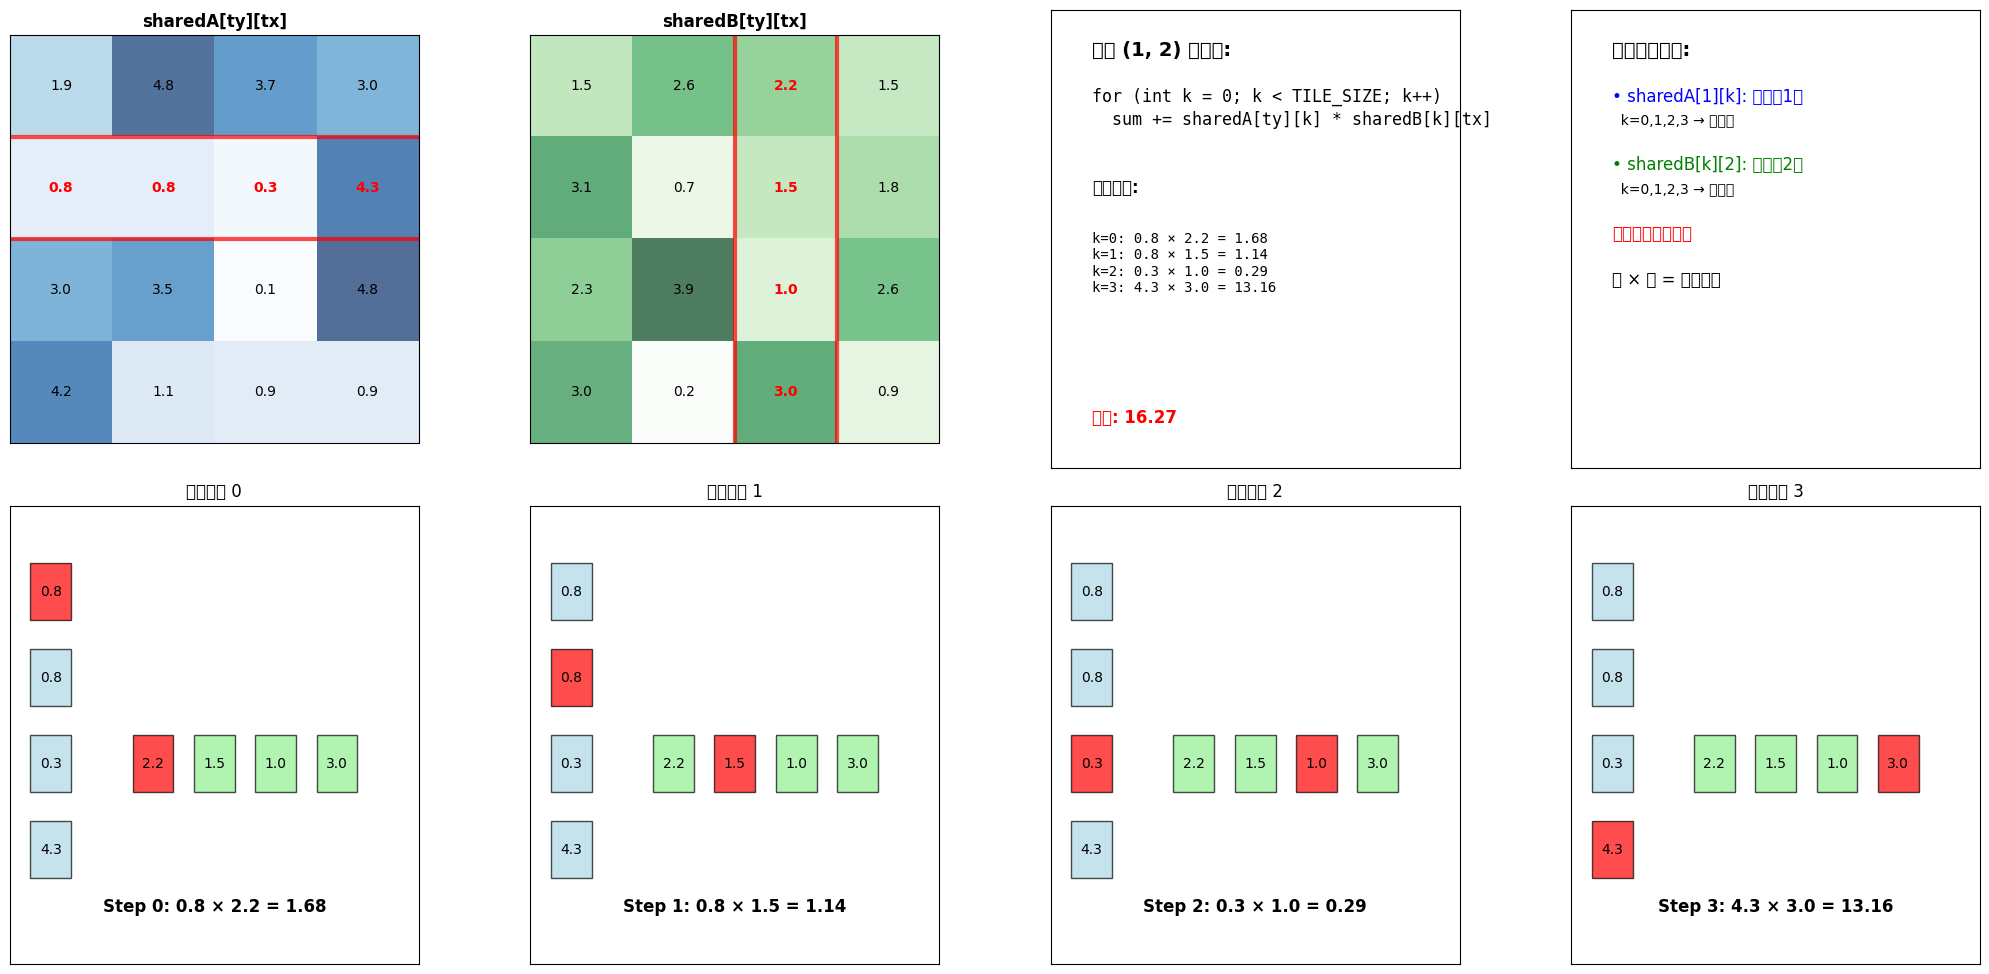

🚀 核心理解：
• sharedA[ty][k]：线程访问自己对应行的所有元素
• sharedB[k][tx]：线程访问自己对应列的所有元素
• 行×列的点积 = 矩阵乘法的一个元素
• 二维数组让行列访问变得非常直观！


In [5]:
# 演示单个线程的计算过程
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# 假设我们要计算 C[1,2] 的值（即线程 ty=1, tx=2）
target_ty, target_tx = 1, 2

# 创建示例数据
np.random.seed(42)
sharedA_data = np.random.rand(4, 4) * 5
sharedB_data = np.random.rand(4, 4) * 5

# 第一行：显示两个共享内存数组
axes[0, 0].imshow(sharedA_data, cmap='Blues', alpha=0.7)
axes[0, 0].set_title('sharedA[ty][tx]', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        color = 'red' if i == target_ty else 'black'
        axes[0, 0].text(j, i, f'{sharedA_data[i, j]:.1f}', 
                       ha='center', va='center', fontsize=10, color=color, fontweight='bold' if i == target_ty else 'normal')
# 高亮显示目标行
axes[0, 0].axhline(y=target_ty-0.5, color='red', linewidth=3, alpha=0.7)
axes[0, 0].axhline(y=target_ty+0.5, color='red', linewidth=3, alpha=0.7)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

axes[0, 1].imshow(sharedB_data, cmap='Greens', alpha=0.7)
axes[0, 1].set_title('sharedB[ty][tx]', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        color = 'red' if j == target_tx else 'black'
        axes[0, 1].text(j, i, f'{sharedB_data[i, j]:.1f}', 
                       ha='center', va='center', fontsize=10, color=color, fontweight='bold' if j == target_tx else 'normal')
# 高亮显示目标列
axes[0, 1].axvline(x=target_tx-0.5, color='red', linewidth=3, alpha=0.7)
axes[0, 1].axvline(x=target_tx+0.5, color='red', linewidth=3, alpha=0.7)
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# 显示计算过程
axes[0, 2].text(0.1, 0.9, f'线程 ({target_ty}, {target_tx}) 的计算:', fontsize=14, fontweight='bold', transform=axes[0, 2].transAxes)
axes[0, 2].text(0.1, 0.8, 'for (int k = 0; k < TILE_SIZE; k++)', fontsize=12, transform=axes[0, 2].transAxes, family='monospace')
axes[0, 2].text(0.1, 0.75, '  sum += sharedA[ty][k] * sharedB[k][tx]', fontsize=12, transform=axes[0, 2].transAxes, family='monospace')

calculation_text = ""
total_sum = 0
for k in range(4):
    val_a = sharedA_data[target_ty, k]
    val_b = sharedB_data[k, target_tx]
    product = val_a * val_b
    total_sum += product
    calculation_text += f'k={k}: {val_a:.1f} × {val_b:.1f} = {product:.2f}\n'

axes[0, 2].text(0.1, 0.6, '计算详情:', fontsize=12, fontweight='bold', transform=axes[0, 2].transAxes)
axes[0, 2].text(0.1, 0.35, calculation_text, fontsize=10, transform=axes[0, 2].transAxes, family='monospace')
axes[0, 2].text(0.1, 0.1, f'总和: {total_sum:.2f}', fontsize=12, fontweight='bold', transform=axes[0, 2].transAxes, color='red')
axes[0, 2].set_xlim(0, 1)
axes[0, 2].set_ylim(0, 1)
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])

# 显示访问模式
axes[0, 3].text(0.1, 0.9, '访问模式分析:', fontsize=14, fontweight='bold', transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.8, '• sharedA[1][k]: 访问第1行', fontsize=12, transform=axes[0, 3].transAxes, color='blue')
axes[0, 3].text(0.1, 0.75, '  k=0,1,2,3 → 一整行', fontsize=10, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.65, '• sharedB[k][2]: 访问第2列', fontsize=12, transform=axes[0, 3].transAxes, color='green')
axes[0, 3].text(0.1, 0.6, '  k=0,1,2,3 → 一整列', fontsize=10, transform=axes[0, 3].transAxes)
axes[0, 3].text(0.1, 0.5, '这就是矩阵乘法！', fontsize=12, fontweight='bold', transform=axes[0, 3].transAxes, color='red')
axes[0, 3].text(0.1, 0.4, '行 × 列 = 结果元素', fontsize=12, transform=axes[0, 3].transAxes)
axes[0, 3].set_xlim(0, 1)
axes[0, 3].set_ylim(0, 1)
axes[0, 3].set_xticks([])
axes[0, 3].set_yticks([])

# 第二行：逐步显示计算过程
for step in range(4):
    ax = axes[1, step]
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    
    # 绘制 sharedA 的行
    for i in range(4):
        color = 'red' if i == step else 'lightblue'
        rect = patches.Rectangle((0.5, 6-i*1.5), 1, 1, facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
        ax.text(1, 6.5-i*1.5, f'{sharedA_data[target_ty, i]:.1f}', ha='center', va='center', fontsize=10)
    
    # 绘制 sharedB 的列
    for i in range(4):
        color = 'red' if i == step else 'lightgreen'
        rect = patches.Rectangle((3+i*1.5, 3), 1, 1, facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
        ax.text(3.5+i*1.5, 3.5, f'{sharedB_data[i, target_tx]:.1f}', ha='center', va='center', fontsize=10)
    
    # 显示当前乘积
    if step < 4:
        product = sharedA_data[target_ty, step] * sharedB_data[step, target_tx]
        ax.text(5, 1, f'Step {step}: {sharedA_data[target_ty, step]:.1f} × {sharedB_data[step, target_tx]:.1f} = {product:.2f}', 
               ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_title(f'计算步骤 {step}', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

print("🚀 核心理解：")
print("• sharedA[ty][k]：线程访问自己对应行的所有元素")
print("• sharedB[k][tx]：线程访问自己对应列的所有元素") 
print("• 行×列的点积 = 矩阵乘法的一个元素")
print("• 二维数组让行列访问变得非常直观！")

## 6. 完整的分块矩阵乘法流程

让我们看看多个 Tile 是如何协作完成整个矩阵乘法的：

/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 34013 (\N{CJK UNIFIED IDEOGRAPH-84DD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 22359 (\N{CJK UNIFIED IDEOGRAPH-5757}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2220079/1364122795.py:113: UserWarning: Glyph 20998 (\N

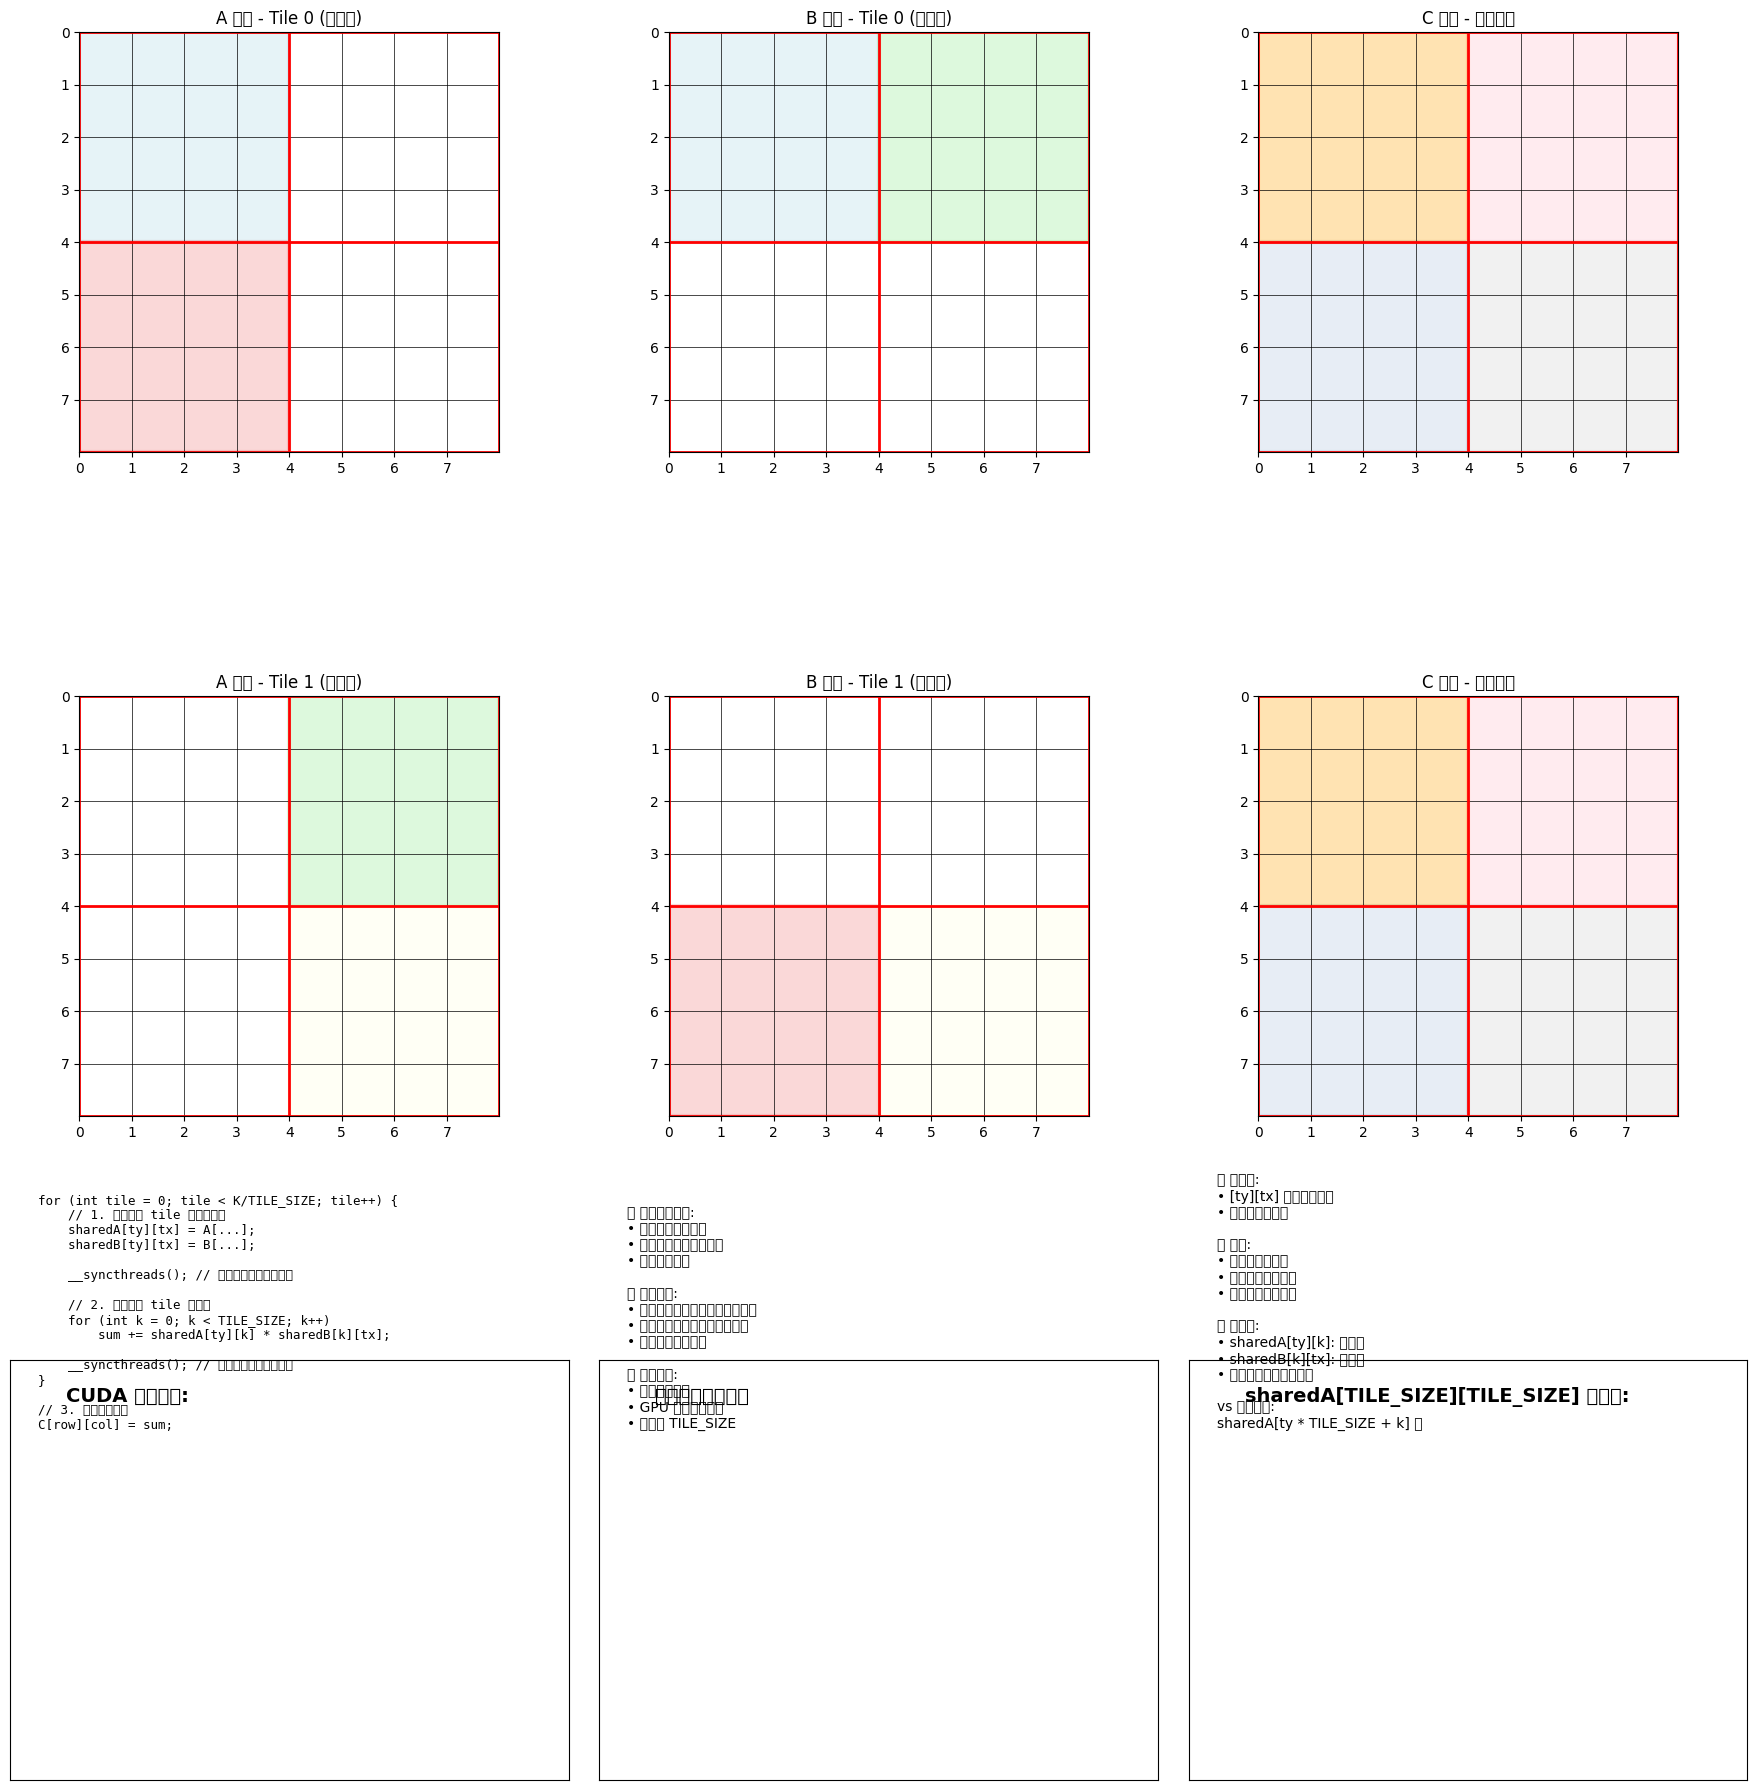

🎉 总结 - 为什么 sharedA 是二维数组：
1. 📐 直观映射：[ty][tx] 直接对应矩阵的行列位置
2. 🎯 访问模式：sharedA[ty][k] 天然地访问第 ty 行的所有元素
3. 💻 代码清晰：比一维数组 sharedA[ty*TILE_SIZE+k] 更易读
4. ⚡ 性能优化：编译器能更好地优化二维数组访问
5. 🔄 数据重用：同一行/列的数据被多个线程重复使用

现在你应该完全理解为什么 CUDA 中使用二维共享内存数组了！


In [6]:
# 展示完整的分块矩阵乘法流程
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# 第一行：显示第一次迭代 (tile = 0)
tile_colors_a = ['lightblue', 'white']
tile_colors_b = ['lightblue', 'white'] 
tile_colors_c = ['orange', 'white']

# Tile 0 的计算
draw_matrix(axes[0, 0], "矩阵 A", M, K, TILE_SIZE, 
           highlight_tiles=[(0, 0, 'lightblue'), (1, 0, 'lightcoral')])
axes[0, 0].set_title('A 矩阵 - Tile 0 (蓝色块)', fontsize=12)

draw_matrix(axes[0, 1], "矩阵 B", K, N, TILE_SIZE,
           highlight_tiles=[(0, 0, 'lightblue'), (0, 1, 'lightgreen')])
axes[0, 1].set_title('B 矩阵 - Tile 0 (蓝色块)', fontsize=12)

draw_matrix(axes[0, 2], "矩阵 C", M, N, TILE_SIZE,
           highlight_tiles=[(0, 0, 'orange'), (0, 1, 'pink'), 
                           (1, 0, 'lightsteelblue'), (1, 1, 'lightgray')])
axes[0, 2].set_title('C 矩阵 - 部分结果', fontsize=12)

# 第二行：显示第二次迭代 (tile = 1)
draw_matrix(axes[1, 0], "矩阵 A", M, K, TILE_SIZE, 
           highlight_tiles=[(0, 1, 'lightgreen'), (1, 1, 'lightyellow')])
axes[1, 0].set_title('A 矩阵 - Tile 1 (绿色块)', fontsize=12)

draw_matrix(axes[1, 1], "矩阵 B", K, N, TILE_SIZE,
           highlight_tiles=[(1, 0, 'lightcoral'), (1, 1, 'lightyellow')])
axes[1, 1].set_title('B 矩阵 - Tile 1 (红色块)', fontsize=12)

draw_matrix(axes[1, 2], "矩阵 C", M, N, TILE_SIZE,
           highlight_tiles=[(0, 0, 'orange'), (0, 1, 'pink'), 
                           (1, 0, 'lightsteelblue'), (1, 1, 'lightgray')])
axes[1, 2].set_title('C 矩阵 - 累加结果', fontsize=12)

# 第三行：算法流程图
axes[2, 0].text(0.1, 0.9, 'CUDA 代码流程:', fontsize=14, fontweight='bold', transform=axes[2, 0].transAxes)
code_text = '''
for (int tile = 0; tile < K/TILE_SIZE; tile++) {
    // 1. 加载当前 tile 到共享内存
    sharedA[ty][tx] = A[...];
    sharedB[ty][tx] = B[...];
    
    __syncthreads(); // 等待所有线程加载完成
    
    // 2. 计算当前 tile 的贡献
    for (int k = 0; k < TILE_SIZE; k++)
        sum += sharedA[ty][k] * sharedB[k][tx];
    
    __syncthreads(); // 等待所有线程计算完成
}

// 3. 写入最终结果
C[row][col] = sum;
'''
axes[2, 0].text(0.05, 0.8, code_text, fontsize=9, transform=axes[2, 0].transAxes, family='monospace')
axes[2, 0].set_xlim(0, 1)
axes[2, 0].set_ylim(0, 1)
axes[2, 0].set_xticks([])
axes[2, 0].set_yticks([])

# 性能优势说明
axes[2, 1].text(0.1, 0.9, '为什么使用分块？', fontsize=14, fontweight='bold', transform=axes[2, 1].transAxes)
perf_text = '''
✅ 内存访问优化:
• 减少全局内存访问
• 利用共享内存高速缓存
• 内存合并访问

✅ 计算效率:
• 数据重用：每个元素被多次使用
• 并行计算：多个线程同时工作
• 减少内存带宽压力

✅ 可扩展性:
• 适用于大矩阵
• GPU 内存限制友好
• 可调节 TILE_SIZE
'''
axes[2, 1].text(0.05, 0.8, perf_text, fontsize=10, transform=axes[2, 1].transAxes)
axes[2, 1].set_xlim(0, 1)
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_xticks([])
axes[2, 1].set_yticks([])

# 二维数组的优势
axes[2, 2].text(0.1, 0.9, 'sharedA[TILE_SIZE][TILE_SIZE] 的优势:', fontsize=14, fontweight='bold', transform=axes[2, 2].transAxes)
array_text = '''
🎯 直观性:
• [ty][tx] 直接对应行列
• 代码易读易维护

🚀 性能:
• 编译器优化友好
• 避免手动索引计算
• 内存访问模式清晰

🔧 实用性:
• sharedA[ty][k]: 访问行
• sharedB[k][tx]: 访问列
• 完美契合矩阵乘法逻辑

vs 一维数组: 
sharedA[ty * TILE_SIZE + k] ❌
'''
axes[2, 2].text(0.05, 0.8, array_text, fontsize=10, transform=axes[2, 2].transAxes)
axes[2, 2].set_xlim(0, 1)
axes[2, 2].set_ylim(0, 1)
axes[2, 2].set_xticks([])
axes[2, 2].set_yticks([])

plt.tight_layout()
plt.show()

print("🎉 总结 - 为什么 sharedA 是二维数组：")
print("1. 📐 直观映射：[ty][tx] 直接对应矩阵的行列位置")
print("2. 🎯 访问模式：sharedA[ty][k] 天然地访问第 ty 行的所有元素")
print("3. 💻 代码清晰：比一维数组 sharedA[ty*TILE_SIZE+k] 更易读")
print("4. ⚡ 性能优化：编译器能更好地优化二维数组访问")
print("5. 🔄 数据重用：同一行/列的数据被多个线程重复使用")
print("\n现在你应该完全理解为什么 CUDA 中使用二维共享内存数组了！")

## 总结

通过这个可视化演示，我们深入理解了：

### 🎯 **为什么 sharedA 是二维数组？**

1. **直观映射矩阵结构**：`sharedA[ty][tx]` 直接对应矩阵元素的行列位置
2. **简化访问模式**：`sharedA[ty][k]` 天然地访问第 `ty` 行的所有元素  
3. **提高代码可读性**：比一维数组索引 `sharedA[ty * TILE_SIZE + k]` 更清晰
4. **编译器优化友好**：二维数组访问模式更容易被编译器优化

### 🚀 **核心算法理解**

- **分块（Tiling）**：将大矩阵分成小块，每个线程块处理一个结果块
- **共享内存**：高速缓存，减少全局内存访问
- **数据重用**：每个共享内存中的元素被多个线程重复使用
- **同步机制**：`__syncthreads()` 确保所有线程协调工作

### 💡 **关键代码解析**

```cuda
for (int k = 0; k < TILE_SIZE; ++k)
    sum += sharedA[ty][k] * sharedB[k][tx];
```

这行代码实现了矩阵乘法的核心：**行与列的点积**
- `sharedA[ty][k]`：当前线程对应行的第 k 个元素
- `sharedB[k][tx]`：当前线程对应列的第 k 个元素
- 二维数组让这个访问模式变得直观而高效！

现在你应该完全理解 CUDA 分块矩阵乘法的工作原理了！🎉